1. https://github.com/foukonana/multi_emotions

2. https://github.com/maelfabien/Multimodal-Emotion-Recognition/tree/master/02-Text 


### method 1

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pathlib 
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
import re 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
dataset='train.tsv'
df = pd.read_csv(dataset, sep='\t', header=None, names=['comment', 'label', 'id'])
df['label'] = df['label'].str.split(',')

In [ ]:
emotion_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment',                     
                'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',                 
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

enkman_mapping = {
        "anger": ["anger", "annoyance", "disapproval"],
        "disgust": ["disgust"],
        "fear": ["fear", "nervousness"],
        "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
        "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
        "surprise": ["surprise", "realization", "confusion", "curiosity"],
        "neutral": ["neutral"],
        }
enkman_mapping_rev = {v:key for key, value in enkman_mapping.items() for v in value}

In [ ]:
# function from Google Research analysis 
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [ ]:
# add emotion label to the label ids
df['emotions'] = df['label'].apply(idx2class)

# use enkman mapping to reduce the emotions to a list of ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
df['mapped_emotions'] = df['emotions'].apply(lambda x: [enkman_mapping_rev[i] for i in x])

# fix issues where ['joy',' joy'] might appear
df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'] = df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'].apply(lambda x: [emotion for emotion in set(x)])

In [ ]:
df

,comment,label,id,emotions,mapped_emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[anger]
3,To make her feel threatened,[14],ed7ypvh,[fear],[fear]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[anger]
...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,[18],edsb738,[love],[joy]
43406,Always thought that was funny but is it a refe...,[6],ee7fdou,[confusion],[surprise]
43407,What are you talking about? Anything bad that ...,[3],efgbhks,[annoyance],[anger]
43408,"More like a baptism, with sexy results!",[13],ed1naf8,[excitement],[joy]


   actual_count  percentage
1         36308       83.64
2          6541       15.07
3           532        1.23
4            28        0.06
5             1        0.00


Text(0.5, 1.0, 'Count of labels')

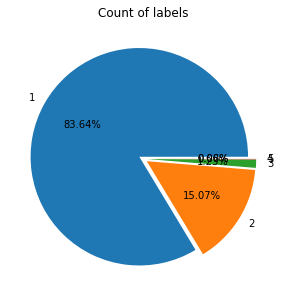

In [ ]:
stats_df = pd.DataFrame(data = {
    'actual_count': df['emotions'].apply(len).value_counts(),
    'percentage': round(df['emotions'].apply(len).value_counts()/df.shape[0]*100, 2)
})

print(stats_df)

plt.figure(figsize=(5,5))
plt.pie(x=stats_df['actual_count'], 
        autopct='%.2f%%', 
        explode=[0.04]*stats_df.shape[0], 
        labels=stats_df.index)
plt.title('Count of labels')

In [ ]:
df['mapped_emotions'].astype(str).value_counts()[:10]

['joy']                15216
['neutral']            12823
['anger']               4293
['surprise']            3858
['sadness']             2326
['joy', 'surprise']      775
['neutral', 'joy']       593
['fear']                 541
['disgust']              498
['anger', 'joy']         352
Name: mapped_emotions, dtype: int64

In [ ]:
emotion_list = ["['joy']", "['neutral']", "['anger']", "['surprise']", "['sadness']", 
                "['surprise', 'joy']", "['neutral', 'joy']", "['fear']", "['disgust']"]


plt.figure(figsize=(16, 12))
for i, multi_emotion in enumerate(emotion_list):
    txt = df.loc[df['mapped_emotions'].astype(str)==multi_emotion, 'comment']

    plt.subplot(3,3,i+1)
    if len(txt)==0:
      wordcloud=WordCloud().generate("empty string")
    else:
      wordcloud = WordCloud().generate(' '.join(txt))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(multi_emotion)
    plt.axis("off")
plt.tight_layout()
plt.show()

NameError: ignored

------

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stemmer = PorterStemmer()
stopword_list = stopwords.words('english')
def process_reddit_comment(strng):
    # remove [NAME] placeholder
    processed_strng = re.sub('\[name]', '', strng)
    # remove reddit symbol 
    processed_strng = re.sub('/r', '', processed_strng)
    return processed_strng
def punct_remover(strng):
    # punctuation marks to be completely removed
    clean_strng = re.sub(r'[?|!|\'|"|#]', r'', strng)
    # punctuation marks to be replaced with space
    clean_strng = re.sub(r'[.|,|)|(|\|/]', r' ', clean_strng)
    # replace multi-space with single space 
    clean_strng = re.sub(r' +', r' ', clean_strng)
    return clean_strng
def tokenize_stem_no_stopwords(strng):
    return [stemmer.stem(w) for w in word_tokenize(strng) if w not in stopword_list]

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# lowercase and remove punctuation 
df['processed_comment'] = df['comment'].str.lower()
df['processed_comment'] = df['processed_comment'].apply(process_reddit_comment)
df['processed_comment'] = df['processed_comment'].apply(punct_remover)
df['processed_comment'] = df['processed_comment'].apply(tokenize_stem_no_stopwords)

In [ ]:
N = df.shape[0]
for emotion in enkman_mapping.keys():
    df[emotion] = np.zeros((N,1), dtype=int)

for emotion in enkman_mapping.keys():
    df[emotion] = df['mapped_emotions'].apply(lambda x: 1 if emotion in x else 0)

In [ ]:
X_train, X_test = train_test_split(df, random_state=156, test_size=0.25, shuffle=True)

In [ ]:
tfidf=TfidfVectorizer()

x_train = tfidf.fit_transform(X_train['processed_comment'].apply(lambda x: ' '.join(x)))
x_test = tfidf.transform(X_test['processed_comment'].apply(lambda x: ' '.join(x)))

modelling

In [ ]:
pip install scikit-multilearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hamming_loss, label_ranking_loss
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.ensemble import RakelD, RakelO
from sklearn.naive_bayes import GaussianNB

In [ ]:
for emotion in enkman_mapping.keys():
    print(f'OneVsRest classification for the emotion of {emotion}')
    clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
    clf.fit(x_train, X_train[emotion])
    y_pred = clf.predict(x_test)
    print(f'Accuracy on {emotion} is {accuracy_score(X_test[emotion], y_pred)*100:.2f}% \n')

OneVsRest classification for the emotion of anger
Accuracy on anger is 88.12% 

OneVsRest classification for the emotion of disgust
Accuracy on disgust is 98.14% 

OneVsRest classification for the emotion of fear
Accuracy on fear is 98.28% 

OneVsRest classification for the emotion of joy
Accuracy on joy is 82.11% 

OneVsRest classification for the emotion of sadness
Accuracy on sadness is 93.57% 

OneVsRest classification for the emotion of surprise
Accuracy on surprise is 88.30% 

OneVsRest classification for the emotion of neutral
Accuracy on neutral is 72.28% 



Problem transformation methods
- binary revelance
- classifierChain
- laber powerset

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance

clf = BinaryRelevance(GaussianNB())
clf.fit(x_train, X_train[enkman_mapping.keys()])
y_pred = clf.predict(x_test)

print(f'Accuracy score is {accuracy_score(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')
print(f'Hamming loss is {hamming_loss(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

clf = ClassifierChain(classifier=GaussianNB())
clf.fit(x_train, X_train[enkman_mapping.keys()])
y_pred = clf.predict(x_test)

print(f'Accuracy score is {accuracy_score(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')
print(f'Hamming loss is {metrics.hamming_loss(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')

In [ ]:
from skmultilearn.problem_transform import  LabelPowerset

clf = LabelPowerset(classifier=GaussianNB())
clf.fit(x_train, X_train[enkman_mapping.keys()])
y_pred = clf.predict(x_test)

print(f'Accuracy score is {accuracy_score(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')
print(f'Hamming loss is {hamming_loss(X_test[enkman_mapping.keys()], y_pred)*100:.2f}% \n')

### method 2